In [1]:
import torch

layer_1 = torch.nn.Linear(2, 2)
layer_2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)

layers = [layer_1, layer_2, softmax]
model = torch.nn.Sequential(*layers)

dataset

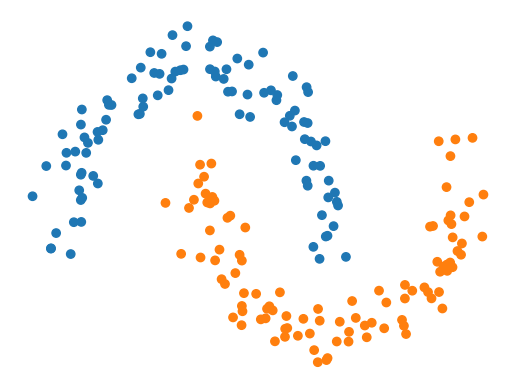

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

#### Q-model

In [25]:
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


In [26]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

### Creating a hybrid model

In [41]:
torch.nn.ReLU()(torch.tensor(-2))

tensor(0)

In [57]:
clayer_1 = torch.nn.Linear(2, 2)
clayer_2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)
# layers = [clayer_1, qlayer, clayer_2, softmax]
layers = [clayer_1, qlayer, torch.nn.Sigmoid(), clayer_2, softmax]
model = torch.nn.Sequential(*layers)

In [58]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
loss = torch.nn.L1Loss()

In [59]:
X_tens = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

batch_size = 5
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X_tens, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

In [69]:

epochs = 6
for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))
    
    y_pred = model(X_tens)
    predictions = torch.argmax(y_pred, axis=1).detach().numpy()
    correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
    accuracy = sum(correct) / len(correct)
    print(f"Accuracy over epoch {epoch + 1}: {accuracy * 100}%")

y_pred = model(X_tens)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.1847
Accuracy over epoch 1: 86.5%
Average loss over epoch 2: 0.1849
Accuracy over epoch 2: 86.5%
Average loss over epoch 3: 0.1823
Accuracy over epoch 3: 87.0%
Average loss over epoch 4: 0.1732
Accuracy over epoch 4: 87.0%
Average loss over epoch 5: 0.1799
Accuracy over epoch 5: 87.0%
Average loss over epoch 6: 0.1778
Accuracy over epoch 6: 87.0%
Accuracy: 87.0%


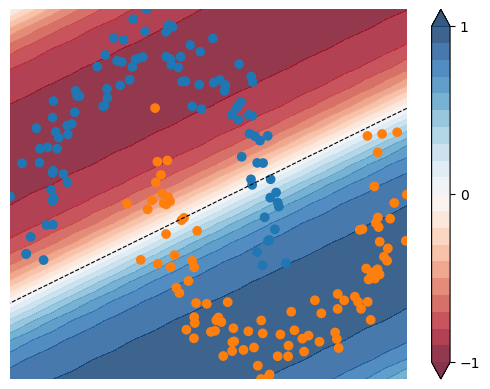

In [70]:
plt.figure()
cm = plt.cm.RdBu

x_range = [X[:,0].min(), X[:,0].max()]
y_range = [X[:,1].min(), X[:,1].max()]
xx, yy = np.meshgrid(np.linspace(*x_range, 20), np.linspace(*y_range, 20))
X_grid = [[x, y] for x, y in zip(xx.flatten(), yy.flatten())]
with torch.no_grad():
    predictions_grid = [model(torch.tensor([x], dtype=torch.float32))[0].numpy() for x in X_grid]
    predictions_grid = [x[1]-x[0] for x in predictions_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()